In [1]:
import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import heapq
import numpy as np
from typing import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class Agent(abc.ABC):
    
    @abc.abstractmethod
    def get_action(self, env, state):
        pass


def try_agent(agent: Agent):
    with gym.make("CartPole-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print("Total reward {0:.2f}".format(total_reward))

In [3]:
"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


try_agent(RandomAgent())

Total reward 36.00


In [4]:
"""
Manual agent (does not take account of speed)
"""


class BrutalAgent(Agent):
    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        if theta < 0.02:
            return 0
        elif theta > 0.02:
            return 1
        return 0


try_agent(BrutalAgent())

Total reward 36.00


In [5]:
"""
Application of PID circuit (limited to linear systems)
"""


# How you do it in the industry

'\nApplication of PID circuit (limited to linear systems)\n'

In [22]:
"""
Cross Entropy Method:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)
=> Look like a kind of genetic algorithm stuff
"""


Episode = namedtuple('Episode', 'states actions score')


class Policy(abc.ABC):
    def get_action(self, state) -> 'action':
        pass
    
    def improve(self, episodes: List[Episode]):
        pass
    

class CrossEntropyAgent(Agent):
    def __init__(self, policy: Policy):
        self.policy = policy
    
    def get_action(self, env, state):
        return self.policy.get_action(state)
    
    def fit(self, env, max_iteration: int = 100, batch_size: int = 1000, batch_threshold: float = 0.7) -> List[float]:
        mean_scores = []
        for _ in range(max_iteration):
            episodes = [self._play_episode(env) for _ in range(batch_size)]
            mean_score = np.mean([episode.score for episode in episodes])
            mean_scores.append(mean_score)
            print("Mean score:", mean_score)
            if mean_score >= 200:
                print("Solved!")
                break
            
            episodes.sort(key=lambda episode: episode.score)
            episodes = episodes[int(batch_threshold*batch_size):]
            self.policy.improve(episodes)
        return mean_scores
    
    def _play_episode(self, env) -> List[Episode]:
        states, actions = [], []
        total_reward = 0.0
        state = env.reset()
        done = False
        while not done:
            action = self.get_action(env, state)
            states.append(state)
            actions.append(action)
            state, reward, done, _ = env.step(action)
            total_reward += reward
        return Episode(states, actions, total_reward)

Mean score: 18.25
Mean score: 34.375
Mean score: 53.5625
Mean score: 64.6875
Mean score: 77.1875
Mean score: 115.125
Mean score: 168.875
Mean score: 200.0
Solved!


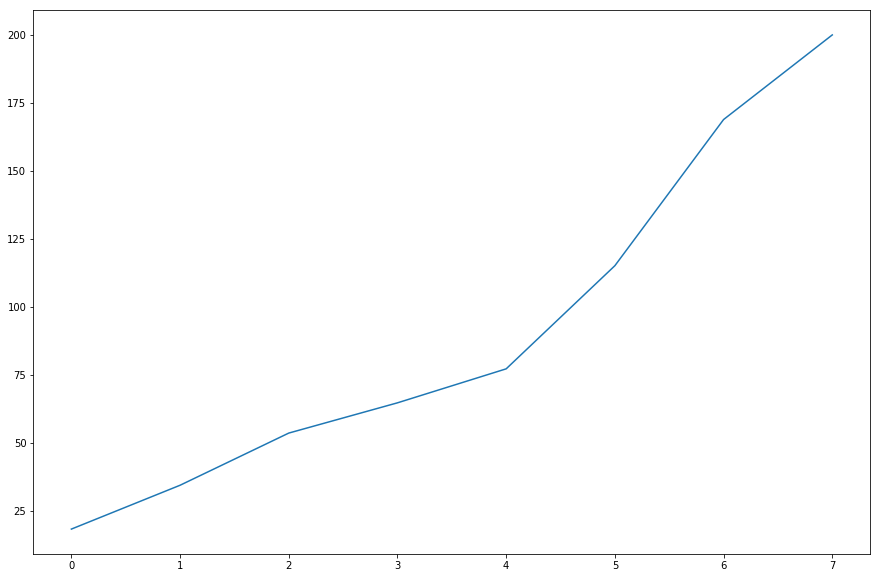

In [28]:
"""
Implementation of a policy to learn via a Neural Net
"""


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


class FullyConnectedNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys


class NeuralNetPolicy(Policy):
    def __init__(self, iteration_nb: int, learning_rate: float, net: nn.Module):
        self.net = net
        self.iteration_nb = iteration_nb
        self.learning_rate = learning_rate
    
    def get_action(self, state) -> 'action':
        self.net.eval()
        xs = torch.FloatTensor(state)
        ys = self.net(xs, with_softmax=True)
        probabilities = ys.detach().numpy()
        action = np.random.choice(len(probabilities), p=probabilities)
        return action
    
    def improve(self, episodes: List[Episode]):
        self.net.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)
        data_set = self._to_data_set(episodes)
        loader = data.DataLoader(data_set, batch_size=100, shuffle=True)
        for _ in range(self.iteration_nb):
            for states, actions in loader:
                optimizer.zero_grad()
                got = self.net(states, with_softmax=False)
                loss = criterion(got, actions)
                loss.backward()
                optimizer.step()

    def _to_data_set(self, episodes: List[Episode]):
        xs, ys = [], []
        for episode in episodes:
            for state, action in zip(episode.states, episode.actions):
                xs.append(state)
                ys.append(action)
        xs = torch.FloatTensor(xs)
        ys = torch.LongTensor(ys)
        return data.TensorDataset(xs, ys)

    
"""
Test with the policy of a neural net
"""


fc_net = FullyConnectedNet(observation_size=4, hidden_size=32, action_size=2)
policy = NeuralNetPolicy(iteration_nb=50, learning_rate=1e-1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

Mean score: 25.0625
Mean score: 30.875
Mean score: 47.0625
Mean score: 54.6875
Mean score: 75.125
Mean score: 96.75
Mean score: 110.0
Mean score: 157.375
Mean score: 167.4375
Mean score: 172.9375
Mean score: 172.5
Mean score: 190.125
Mean score: 182.375
Mean score: 192.5625
Mean score: 167.9375
Mean score: 172.25
Mean score: 191.75
Mean score: 179.4375
Mean score: 175.3125
Mean score: 164.625
Mean score: 198.0
Mean score: 193.25
Mean score: 183.3125
Mean score: 186.8125
Mean score: 188.3125
Mean score: 192.5
Mean score: 195.5625
Mean score: 195.875
Mean score: 194.125
Mean score: 193.3125
Mean score: 186.875
Mean score: 187.6875
Mean score: 193.8125
Mean score: 188.9375
Mean score: 195.25
Mean score: 200.0
Solved!


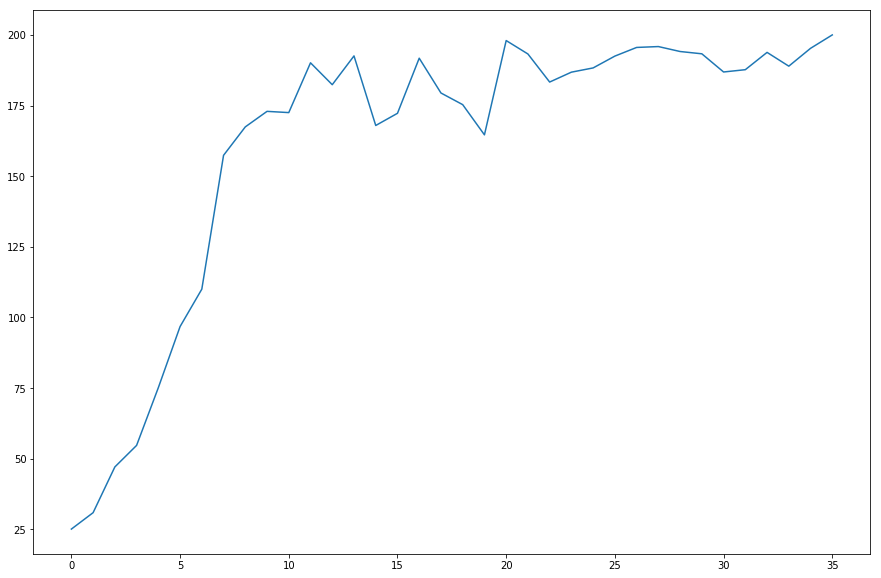

In [26]:
"""
Implementation with feature engineering (polynomial) and a linear model
"""


class LinearNet(nn.Module):
    def __init__(self, observation_size, action_size):
        super().__init__()
        self.fc = nn.Linear(observation_size, action_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys


class PolynomialRegressionPolicy(Policy):
    def __init__(self, iteration_nb: int, learning_rate: float):
        observation_size = self._transform(np.zeros((4,))).shape[0]
        self.net = LinearNet(observation_size=observation_size, action_size=2)
        self.iteration_nb = iteration_nb
        self.learning_rate = learning_rate
    
    def get_action(self, state) -> 'action':
        self.net.eval()
        xs = torch.FloatTensor(self._transform(state))
        ys = self.net(xs, with_softmax=True)
        probabilities = ys.detach().numpy()
        action = np.random.choice(len(probabilities), p=probabilities)
        return action
    
    def improve(self, episodes: List[Episode]):
        self.net.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)
        data_set = self._to_data_set(episodes)
        loader = data.DataLoader(data_set, batch_size=100, shuffle=True)
        for _ in range(self.iteration_nb):
            for states, actions in loader:
                optimizer.zero_grad()
                got = self.net(states, with_softmax=False)
                loss = criterion(got, actions)
                loss.backward()
                optimizer.step()
                
    def _to_data_set(self, episodes: List[Episode]):
        xs, ys = [], []
        for episode in episodes:
            for state, action in zip(episode.states, episode.actions):
                xs.append(self._transform(state))
                ys.append(action)
        xs = torch.FloatTensor(xs)
        ys = torch.LongTensor(ys)
        return data.TensorDataset(xs, ys)

    def _transform(self, state):
        new_state = list(state)
        k = len(state)
        for i in range(k-1):
            for j in range(i+1, k):
                new_state.append(state[i] * state[j])
        return np.array(new_state)


"""
Test with the policy of polynomial regression
"""


agent = CrossEntropyAgent(policy=PolynomialRegressionPolicy(iteration_nb=50, learning_rate=1e-1))
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

In [114]:
"""
With Deep Q-Learning
"""


Experience = namedtuple('Experience', 'state action next_state reward done')


class RegressionNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations):
        ys = self.fc(observations)
        return ys

    
class NeuralNetQValues:
    def __init__(self, iteration_nb: int, learning_rate: float):
        self.net = RegressionNet(observation_size=4, hidden_size=100, action_size=2)
        self.iteration_nb = iteration_nb
        self.learning_rate = learning_rate
    
    def get_value(self, state, action):
        ys = self._action_values(state)
        return ys.detach().numpy()[action]
    
    def best_action(self, state) -> 'action':
        ys = self._action_values(state)
        return torch.argmax(ys).item()
    
    def _action_values(self, state):
        self.net.eval()
        xs = torch.FloatTensor(state)
        return self.net(xs)
    
    def improve(self, experiences: List[Experience]):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)
        data_set = self._to_data_set(experiences)
        loader = data.DataLoader(data_set, batch_size=100, shuffle=True)
        self.net.train()
        for _ in range(self.iteration_nb):
            for states, actions, expected_values in loader:
                optimizer.zero_grad()
                q_values = self.net(states)
                got = self._gather_action_values(q_values, actions)
                loss = criterion(got, expected_values)
                loss.backward()
                optimizer.step()

    def _gather_action_values(self, out_values, actions):
        action_indices = actions.unsqueeze(dim=-1)
        values = torch.gather(out_values, dim=-1, index=action_indices)
        return values.squeeze(dim=-1)
                
    def _to_data_set(self, experiences: List[Experience]):
        states = []
        actions = []
        q_values = []
        for experience in experiences:
            states.append(experience.state)
            actions.append(experience.action)
            q_values.append(experience.reward)

        self.net.eval()
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        prev_values = self._gather_action_values(self.net(states), actions)
        for i, val in enumerate(prev_values):
            if not experiences[i].done:
                q_values[i] += val.item()
        q_values = torch.FloatTensor(q_values)
        return data.TensorDataset(states, actions, q_values)
    

class DeepQLearningAgent(Agent):
    def __init__(self,
                 q_values: NeuralNetQValues,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        self.epsilon = epsilon
        self.reward_discount = reward_discount
        self.q_values = q_values
    
    def get_action(self, env, state):
        if self.epsilon > 0. and np.random.random() < self.epsilon:
            return env.action_space.sample()
        return self.q_values.best_action(state)
    
    def fit(self, env,
            max_iteration: int = 100,
            epsilon_decrease: float = 0.,
            batch_size: int = 1000) -> List[float]:
        
        mean_scores = []
        for _ in range(max_iteration):
            episode_nb = 0
            total_score = 0.
            experiences = []
            while len(experiences) < batch_size:
                episode_experiences, episode_score = self._play_episode(env)
                experiences.extend(episode_experiences)
                total_score += episode_score
                episode_nb += 1
            
            mean_score = total_score / episode_nb
            mean_scores.append(mean_score)
            print("Mean score:", mean_score)
            if mean_score >= 200:
                break
            
            self.q_values.improve(experiences)
            self.epsilon -= epsilon_decrease
        return mean_scores
    
    def _play_episode(self, env):
        experiences = []
        total_reward = 0.0
        state = env.reset()
        done = False
        while not done:
            action = self.get_action(env, state)
            next_state, reward, done, _ = env.step(action)
            experiences.append(Experience(state, action, next_state, reward, done))
            total_reward += reward
            state = next_state
        return experiences, total_reward

In [116]:
agent = DeepQLearningAgent(
    q_values=NeuralNetQValues(iteration_nb=100, learning_rate=1e-1),
    reward_discount=1.0,
    epsilon=0.5)

with gym.make("CartPole-v0") as env:
    max_iterations = 100
    scores = agent.fit(env,
                       epsilon_decrease= 0., # (0.5 - 0.1) / max_iterations,
                       max_iteration = max_iterations,
                       batch_size = 2_000)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

Mean score: 13.353333333333333
Mean score: 13.815068493150685
Mean score: 13.63265306122449
Mean score: 13.143790849673202
Mean score: 12.078313253012048
Mean score: 14.292857142857143
Mean score: 13.848275862068965
Mean score: 14.932835820895523
Mean score: 20.484848484848484
Mean score: 27.08108108108108
Mean score: 13.463087248322148
Mean score: 13.83448275862069
Mean score: 29.808823529411764
Mean score: 40.46
Mean score: 38.76923076923077
Mean score: 18.906542056074766
Mean score: 23.53488372093023
Mean score: 37.2037037037037
Mean score: 21.77173913043478
Mean score: 46.25
Mean score: 50.7
Mean score: 43.854166666666664
Mean score: 14.467625899280575
Mean score: 46.53488372093023
Mean score: 52.94736842105263
Mean score: 39.3921568627451
Mean score: 61.303030303030305
Mean score: 44.130434782608695
Mean score: 42.59574468085106
Mean score: 23.88095238095238
Mean score: 27.16216216216216
Mean score: 34.724137931034484
Mean score: 55.916666666666664
Mean score: 14.364285714285714
M

KeyboardInterrupt: 

In [69]:
"""
How gather works
"""

xs = torch.FloatTensor([
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8]
])

torch.gather(xs, dim=-1, index=torch.LongTensor([[0], [1], [2]])).squeeze(dim=-1)

tensor([0., 4., 8.])